# EmbedX: Multi-lingual Embedding Model

## Project Overview

- EmbedX is an Natural Language Processing project focused on developing and comparing different word embedding approaches across multiple languages. 
- The project aims to evaluate the effectiveness of various embedding techniques through practical applications in chatbot development and comprehensive comparative analysis.

## Key Components of this project

- **Part 1.** Multi-lingual Word2Vec Implementation
    - Focus on creating a model to produce Word2Vec embeddings for non-English languages.

- **Part 2.** RNN-based Embedding Architecture 
    - Development of a custom RNN architecture for embedding generation. 
    - Comparative analysis against standard Keras Word2Vec embeddings.

- **Part 3.** Chatbot Integration & Evaluation 
    - Development of an embedding-powered chatbot system.
    - Comparative testing between English and non-English embedding models
    - Performance benchmarking across different embedding sources


- **Part 4.** Embedding Quality Assessment
    - Comparative analysis of Word2Vec and RNN-based approaches
    - Implementation of multiple evaluation metrics


- **Part 5.** DNN Comparative Study
    - Implementation of a shallow DNN for embedding generation
    - Head-to-head comparison with RNN-based embeddings

## Priority Focus
- The core focus is on developing and optimizing the RNN-based embedding architecture, as this forms the foundation for subsequent comparative analyses and applications.

---

## Part 3. Chatbot Integration & Evaluation 
- Development of an embedding-powered chatbot system.
- Comparative testing between English and non-English embedding models
- Performance benchmarking across different embedding sources

### Approach

- Import necessary libraries

In [ ]:
import copy
import pandas as pd
import numpy as np
import string
from string import digits

import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from indicnlp import common
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, RepeatVector

import re

### Prepare Data
- We follow the same procedure as before to preprocess our text which includes removing puntuations, numbers, tokenizing, and tagging each sentence

In [ ]:
def tokenize_text(text):
    return list(indic_tokenize.trivial_tokenize(text))

def normalize_text(text):
    normalizer = IndicNormalizerFactory().get_normalizer("hi")  # "hi" for Hindi
    return normalizer.normalize(text)

def remove_numbers(text):
    text = str(text)
    text = text.replace('\n', '')
    # Regex that matches both Hindi numerals (०-९) and standard numerals (0-9)
    return re.sub(r'[०१२३४५६७८९0-9]', '', text)

def remove_punctuation(text):
    # List of common punctuation marks in Hindi
    hindi_punctuation = ['।','॥', ',', '?', '$', '!', '“', '”', '‘', '’', '—', '-', '(', ')', ':', ';', '"', "'", '...']
    return ' '.join(char for char in text if char not in hindi_punctuation)

def tag_sentence(w):
    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def preprocess_text(text):
    # Normalize text
    text = normalize_text(text)
    
    # Tokenize text
    tokens = tokenize_text(text)
    
    tokens = remove_punctuation(tokens)
    
    tokens = remove_numbers(tokens)

    tokens = remove_multiple_spaces(tokens)
 
    return tokens

In [ ]:
with open("dataset/Panchtantra.txt", 'r', encoding="utf-8") as file_data: 
    text = file_data.read()

text = text.replace('\n', ' ')
sentences = text.split("।")
sentences = [preprocess_text(sent).lstrip(' ') for sent in sentences]
sentences

['पंचतंत्र की कहानियां पंचतंत्र नीति कथा और कहानियों का संग्रह है जिसके रचयिता आचार्य विष्णु शर्मा है',
 'पंचतंत्र की कहानी में बच्चों के साथ साथ बड़े भी रुचि लेते हैं',
 'पंचतंत्र की कहानी के पीछे कोई ना कोई शिक्षा या मूल छिपा होता है जो हमें सीख देती है',
 'पंचतंत्र की कहानी बच्चे बड़ी चाव से पढ़ते हैं तथा सीख लेते हैं',
 'पंचतंत्र की कछ कहानियां ऐसी भी है जो हिंदी में कहानी लेखन में दी जाती हैं तथा इसके साथ साथ कई परीक्षाओं में भी',
 '',
 'कुछ पाठयपृस्तक में दी होती है जो लिखने को आती हैं',
 'महत्वपूर्ण और आकर्षक कहानियां इस ब्लॉग में दी गई हैं',
 'आचार्य विष्ण शर्मा संस्कत के लेखक विष्णु शर्मा पंचतंत्र संस्कत की नीति पर्तक के लेखक माने जाते हैं',
 'जब यह ग्रंथ बनकर तैयार हुआ तब विष्ण शर्मा की उम्र सात्र थी',
 'विष्ण शर्मा दक्षिण भारत के महिलारोप्य नामक नगर में रहते थे',
 'एक राजा के मर्ख पत्र थे जिनकी जिम्मेदारी विष्ण शर्मा को दे दी गई विष्ण शर्मा को यह पता था कि यह इतने मूर्ख हैं कि इनको प्राने तरीकों से नहीं पढ़ाया जा सकता तब उन्होंने जंत कथाओं के द्वारा पढ़ाने का निश्चय किया',
 

In [4]:
sentences = [tag_sentence(sent) for sent in sentences]
sentences

['<start> पंचतंत्र की कहानियां पंचतंत्र नीति कथा और कहानियों का संग्रह है जिसके रचयिता आचार्य विष्णु शर्मा है <end>',
 '<start> पंचतंत्र की कहानी में बच्चों के साथ साथ बड़े भी रुचि लेते हैं <end>',
 '<start> पंचतंत्र की कहानी के पीछे कोई ना कोई शिक्षा या मूल छिपा होता है जो हमें सीख देती है <end>',
 '<start> पंचतंत्र की कहानी बच्चे बड़ी चाव से पढ़ते हैं तथा सीख लेते हैं <end>',
 '<start> पंचतंत्र की कछ कहानियां ऐसी भी है जो हिंदी में कहानी लेखन में दी जाती हैं तथा इसके साथ साथ कई परीक्षाओं में भी <end>',
 '<start>  <end>',
 '<start> कुछ पाठयपृस्तक में दी होती है जो लिखने को आती हैं <end>',
 '<start> महत्वपूर्ण और आकर्षक कहानियां इस ब्लॉग में दी गई हैं <end>',
 '<start> आचार्य विष्ण शर्मा संस्कत के लेखक विष्णु शर्मा पंचतंत्र संस्कत की नीति पर्तक के लेखक माने जाते हैं <end>',
 '<start> जब यह ग्रंथ बनकर तैयार हुआ तब विष्ण शर्मा की उम्र सात्र थी <end>',
 '<start> विष्ण शर्मा दक्षिण भारत के महिलारोप्य नामक नगर में रहते थे <end>',
 '<start> एक राजा के मर्ख पत्र थे जिनकी जिम्मेदारी विष्ण शर्म

In [5]:
text = ' '.join(sentences)
text[:1000]

'<start> पंचतंत्र की कहानियां पंचतंत्र नीति कथा और कहानियों का संग्रह है जिसके रचयिता आचार्य विष्णु शर्मा है <end> <start> पंचतंत्र की कहानी में बच्चों के साथ साथ बड़े भी रुचि लेते हैं <end> <start> पंचतंत्र की कहानी के पीछे कोई ना कोई शिक्षा या मूल छिपा होता है जो हमें सीख देती है <end> <start> पंचतंत्र की कहानी बच्चे बड़ी चाव से पढ़ते हैं तथा सीख लेते हैं <end> <start> पंचतंत्र की कछ कहानियां ऐसी भी है जो हिंदी में कहानी लेखन में दी जाती हैं तथा इसके साथ साथ कई परीक्षाओं में भी <end> <start>  <end> <start> कुछ पाठयपृस्तक में दी होती है जो लिखने को आती हैं <end> <start> महत्वपूर्ण और आकर्षक कहानियां इस ब्लॉग में दी गई हैं <end> <start> आचार्य विष्ण शर्मा संस्कत के लेखक विष्णु शर्मा पंचतंत्र संस्कत की नीति पर्तक के लेखक माने जाते हैं <end> <start> जब यह ग्रंथ बनकर तैयार हुआ तब विष्ण शर्मा की उम्र सात्र थी <end> <start> विष्ण शर्मा दक्षिण भारत के महिलारोप्य नामक नगर में रहते थे <end> <start> एक राजा के मर्ख पत्र थे जिनकी जिम्मेदारी विष्ण शर्मा को दे दी गई विष्ण शर्मा को यह पता था कि यह 

### Tokenization

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

# Create sequences for next word prediction
sequence_length = 3
sequences = []

# Assuming sentences are split by period
for sentence in sentences:  
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(sequence_length, len(tokens)):
        sequences.append(tokens[i-sequence_length:i+1])

# Convert sequences to numpy array
sequences = np.array(sequences)
X_train = sequences[:, :-1]  # Input sequence
y_train = sequences[:, -1]   # Output next token

In [7]:
X_train.shape, y_train.shape

((2794, 3), (2794,))

## 1. ChatBot building with Word2Vec Embeddings

- We use the vector embeddings generated by Word2Vec from Part 1 to train our Chatbot

In [8]:
from gensim.models import Word2Vec

# Load the Word2Vec model
model = Word2Vec.load("models/hindi_word2vec.model")

In [9]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

927

In [10]:
import numpy as np

# Define the size of the word vectors (same as the vector size of Word2Vec)
embedding_dim = model.vector_size

# Create an empty embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # vocab_size is the size of your vocabulary

# Fill the embedding matrix
for word, i in tokenizer.word_index.items():  # word_index is the dictionary of words to indices
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]

In [11]:
embedding_matrix.shape

(927, 100)

- **Build the chatbot model with Word2Vec Word Embeddings**

- We'll build an RNN model to use LSTM, Embedding, and Dense layers with `Adam` optimizer, `softmax` function, and `sparse_categorical_crossentropy` for our loss function (classification task)

In [ ]:
model = Sequential()

model.add(Embedding(
    input_dim   = vocab_size, 
    output_dim  = embedding_dim, 
    weights     = [embedding_matrix], 
    input_length= sequence_length, 
    trainable   = False
))

# LSTM layer for sequence prediction
model.add(LSTM(256, return_sequences=False))

# Output layer
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

model.summary()

/Users/devanshugohil/anaconda3/envs/tf-1/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-11-06 12:38:18.854152: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-06 12:38:18.854183: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-06 12:38:18.854189: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-06 12:38:18.854201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-06 12:38:18.854209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undef

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │        92,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,700 (362.11 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 92,700 (362.11 KB)

- Training our model

In [13]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=500, 
    batch_size=64, 
    validation_split=0.2
)

Epoch 1/500


2024-11-06 12:38:19.775352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0875 - loss: 6.8057 - val_accuracy: 0.0680 - val_loss: 6.4928
Epoch 2/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1112 - loss: 5.9237 - val_accuracy: 0.0680 - val_loss: 6.5121
Epoch 3/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1075 - loss: 5.6932 - val_accuracy: 0.0680 - val_loss: 6.7450
Epoch 4/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1133 - loss: 5.6136 - val_accuracy: 0.0680 - val_loss: 6.8613
Epoch 5/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1036 - loss: 5.5799 - val_accuracy: 0.0680 - val_loss: 6.9027
Epoch 6/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0990 - loss: 5.6364 - val_accuracy: 0.0680 - val_loss: 7.0270
Epoch 7/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0950 - loss: 5.6111 - val_accuracy: 0.0680 - val_loss: 6.9463
Epoch 8/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0945 - loss: 5.6145 - val_accuracy: 0.0680 - val_l

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1094 - loss: 5.2914 - val_accuracy: 0.0662 - val_loss: 8.0648
Epoch 52/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0902 - loss: 5.3576 - val_accuracy: 0.0662 - val_loss: 8.0309
Epoch 53/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1055 - loss: 5.2713 - val_accuracy: 0.0644 - val_loss: 7.9864
Epoch 54/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1074 - loss: 5.2971 - val_accuracy: 0.0662 - val_loss: 8.2851
Epoch 55/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0992 - loss: 5.2943 - val_accuracy: 0.0626 - val_loss: 8.1833
Epoch 56/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0995 - loss: 5.2626 - val_accuracy: 0.0662 - val_loss: 8.3309
Epoch 57/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0976 - loss: 5.2538 - val_accuracy: 0.0626 - val_loss: 8.2231
Epoch 58/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0985 - loss: 5.2132 - val_accuracy: 0.0662 - 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1545 - loss: 3.8616 - val_accuracy: 0.0626 - val_loss: 10.7920
Epoch 102/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1681 - loss: 3.7777 - val_accuracy: 0.0662 - val_loss: 10.9185
Epoch 103/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1751 - loss: 3.7560 - val_accuracy: 0.0644 - val_loss: 11.0643
Epoch 104/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1592 - loss: 3.7453 - val_accuracy: 0.0716 - val_loss: 11.0092
Epoch 105/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1739 - loss: 3.6621 - val_accuracy: 0.0644 - val_loss: 11.0652
Epoch 106/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1833 - loss: 3.6339 - val_accuracy: 0.0698 - val_loss: 11.2215
Epoch 107/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1839 - loss: 3.6093 - val_accuracy: 0.0680 - val_loss: 11.5629
Epoch 108/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1860 - loss: 3.5864 - val_accu

Epoch 151/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4503 - loss: 2.2431 - val_accuracy: 0.0447 - val_loss: 13.0969
Epoch 152/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4666 - loss: 2.2187 - val_accuracy: 0.0358 - val_loss: 12.9437
Epoch 153/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4371 - loss: 2.2571 - val_accuracy: 0.0447 - val_loss: 13.1637
Epoch 154/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4741 - loss: 2.1684 - val_accuracy: 0.0429 - val_loss: 13.1568
Epoch 155/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4490 - loss: 2.1630 - val_accuracy: 0.0483 - val_loss: 13.2392
Epoch 156/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4746 - loss: 2.1193 - val_accuracy: 0.0376 - val_loss: 13.1724
Epoch 157/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4915 - loss: 2.0990 - val_accuracy: 0.0411 - val_loss: 13.2066
Epoch 158/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4675 - loss: 2.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6548 - loss: 1.4670 - val_accuracy: 0.0411 - val_loss: 14.2941
Epoch 201/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6537 - loss: 1.4502 - val_accuracy: 0.0322 - val_loss: 14.0995
Epoch 202/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6607 - loss: 1.4409 - val_accuracy: 0.0376 - val_loss: 14.1678
Epoch 203/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6619 - loss: 1.4340 - val_accuracy: 0.0358 - val_loss: 14.2703
Epoch 204/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6528 - loss: 1.4277 - val_accuracy: 0.0376 - val_loss: 14.2616
Epoch 205/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6693 - loss: 1.3939 - val_accuracy: 0.0286 - val_loss: 14.1991
Epoch 206/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6696 - loss: 1.3787 - val_accuracy: 0.0358 - val_loss: 14.2801
Epoch 207/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6780 - loss: 1.3711 - val_accur

Epoch 250/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7636 - loss: 1.0022 - val_accuracy: 0.0411 - val_loss: 15.1363
Epoch 251/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7852 - loss: 0.9749 - val_accuracy: 0.0322 - val_loss: 15.1371
Epoch 252/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7697 - loss: 0.9248 - val_accuracy: 0.0340 - val_loss: 15.0866
Epoch 253/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7803 - loss: 0.9283 - val_accuracy: 0.0376 - val_loss: 15.2055
Epoch 254/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7759 - loss: 0.9486 - val_accuracy: 0.0304 - val_loss: 15.2019
Epoch 255/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7807 - loss: 0.9555 - val_accuracy: 0.0358 - val_loss: 15.1965
Epoch 256/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7797 - loss: 0.9337 - val_accuracy: 0.0358 - val_loss: 15.2039
Epoch 257/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7870 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8421 - loss: 0.7024 - val_accuracy: 0.0411 - val_loss: 15.9680
Epoch 300/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8381 - loss: 0.6875 - val_accuracy: 0.0429 - val_loss: 15.9202
Epoch 301/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8367 - loss: 0.6965 - val_accuracy: 0.0447 - val_loss: 15.8959
Epoch 302/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8407 - loss: 0.6656 - val_accuracy: 0.0411 - val_loss: 16.0015
Epoch 303/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8427 - loss: 0.6919 - val_accuracy: 0.0429 - val_loss: 15.8912
Epoch 304/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8335 - loss: 0.6974 - val_accuracy: 0.0465 - val_loss: 15.9339
Epoch 305/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8479 - loss: 0.6709 - val_accuracy: 0.0411 - val_loss: 16.0442
Epoch 306/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8453 - loss: 0.6709 - val_acc

Epoch 349/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8835 - loss: 0.4947 - val_accuracy: 0.0429 - val_loss: 16.6171
Epoch 350/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8925 - loss: 0.4981 - val_accuracy: 0.0465 - val_loss: 16.6373
Epoch 351/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8720 - loss: 0.5223 - val_accuracy: 0.0465 - val_loss: 16.6452
Epoch 352/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8787 - loss: 0.5071 - val_accuracy: 0.0429 - val_loss: 16.6928
Epoch 353/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8655 - loss: 0.5244 - val_accuracy: 0.0411 - val_loss: 16.7540
Epoch 354/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8756 - loss: 0.5051 - val_accuracy: 0.0411 - val_loss: 16.7406
Epoch 355/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8720 - loss: 0.4999 - val_accuracy: 0.0376 - val_loss: 16.5282
Epoch 356/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8806 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9091 - loss: 0.4000 - val_accuracy: 0.0483 - val_loss: 17.3260
Epoch 399/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9062 - loss: 0.3919 - val_accuracy: 0.0394 - val_loss: 17.1699
Epoch 400/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9008 - loss: 0.4053 - val_accuracy: 0.0429 - val_loss: 17.2193
Epoch 401/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9032 - loss: 0.3888 - val_accuracy: 0.0394 - val_loss: 17.1354
Epoch 402/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8887 - loss: 0.4311 - val_accuracy: 0.0465 - val_loss: 17.3613
Epoch 403/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9118 - loss: 0.3790 - val_accuracy: 0.0465 - val_loss: 17.4114
Epoch 404/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8980 - loss: 0.3764 - val_accuracy: 0.0447 - val_loss: 17.3634
Epoch 405/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9022 - loss: 0.3807 - val_acc

Epoch 448/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9225 - loss: 0.3074 - val_accuracy: 0.0465 - val_loss: 17.6206
Epoch 449/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9366 - loss: 0.2902 - val_accuracy: 0.0429 - val_loss: 17.7565
Epoch 450/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9190 - loss: 0.3263 - val_accuracy: 0.0394 - val_loss: 17.8167
Epoch 451/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9235 - loss: 0.2940 - val_accuracy: 0.0394 - val_loss: 17.8004
Epoch 452/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9241 - loss: 0.3100 - val_accuracy: 0.0501 - val_loss: 17.8900
Epoch 453/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9208 - loss: 0.3175 - val_accuracy: 0.0411 - val_loss: 17.8424
Epoch 454/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9174 - loss: 0.3097 - val_accuracy: 0.0447 - val_loss: 17.8405
Epoch 455/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9155 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9283 - loss: 0.2634 - val_accuracy: 0.0519 - val_loss: 18.2984
Epoch 498/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9354 - loss: 0.2492 - val_accuracy: 0.0465 - val_loss: 18.3509
Epoch 499/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9282 - loss: 0.2594 - val_accuracy: 0.0483 - val_loss: 18.3919
Epoch 500/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9270 - loss: 0.2643 - val_accuracy: 0.0537 - val_loss: 18.4152


- Visualizing our model's accuracy

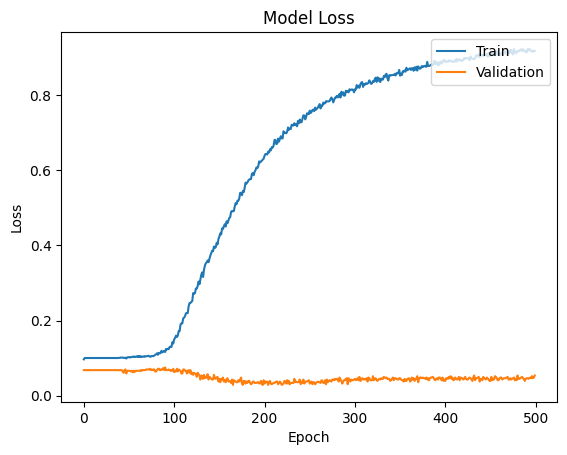

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


- Our model achieves an accuracy around 93% for the training data with Word2Vec vector embeddings

- Saving and loading our model to generate text

In [15]:
# Saving the model via Tensorflow's save() method
model.save('models/nlp_hindi_model_part_1.h5')  

In [16]:
from tensorflow.keras.models import load_model
# Loading the model
model_word2vec = load_model('models/nlp_hindi_model_part_1.h5')

In [17]:
def generate_text(seed_text, num_sentences, model, max_sequence_len, tokenizer, max_length=30):
    generated_text = seed_text
    sentences_generated = 0
    
    while sentences_generated < num_sentences:
        words_in_current_sentence = 0
        
        while words_in_current_sentence < max_length:
            token_list = tokenizer.texts_to_sequences([generated_text])[0]
            token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
            
            # Make prediction
            predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
            
            # Convert prediction to word
            output_word = ""
            for word, index in tokenizer.word_index.items():
                if index == predicted:
                    output_word = word
                    break
            
            # Add the new word
            generated_text += " " + output_word
            words_in_current_sentence += 1
            
            # Check if sentence ended
            if output_word.endswith(('.', '!', '?')) or output_word in ['.', '!', '?']:
                sentences_generated += 1
                break
        
        # Force end sentence if it exceeds the length 
        if words_in_current_sentence >= max_length and sentences_generated < num_sentences:
            generated_text += "."
            sentences_generated += 1
    
    return generated_text

In [ ]:
paragraph = generate_text(
    seed_text       = input("Enter a sentence:"),
    num_sentences   = 1,
    model           = model_word2vec,
    max_sequence_len= sequence_length,
    tokenizer       = tokenizer,
    max_length      = 20
)

word2Vec_res = paragraph.replace("end", "")
word2Vec_res

Enter a sentence:एक बार एक कुत्ता


'एक बार एक कुत्ता बहुत भूख था वह भोजन की तलाश में इधर उधर गया  कसाई की जैसे के पीछे कर ना दिन.'

- Our model can build meaningful sentences by using our Word2Vec embeddings

## 2. ChatBot building with RNN word Embeddings

- We'll use the vector embeddings generated by our RNN model in Part 2 (which is saved as `hindi_word_embeddings.txt`)

In [ ]:
# Load the word embeddings
file_path = 'embeddings/hindi_word_embeddings.txt'

hindi_embeddings = {}
f = open(file_path, encoding='utf8')
try:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        hindi_embeddings[word] = coefs
except:
    print(line)
f.close()

print('Found %s word vectors.' % len(hindi_embeddings))

Found 1020 word vectors.


- Create the embedding matrix from the embedding file

In [20]:
# Define the size of the word vectors (same as the vector size of Word2Vec)
embedding_dim = 100

# Create an empty embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # vocab_size is the size of your vocabulary

# Fill the embedding matrix
for word, i in tokenizer.word_index.items():  # word_index is the dictionary of words to indices
    if word in hindi_embeddings:
        embedding_matrix[i] = hindi_embeddings[word]

- **Building our chatbot with the embedding generated by our RNN model**

In [ ]:
model = Sequential()

model.add(Embedding(
    input_dim   = vocab_size, 
    output_dim  = embedding_dim, 
    weights     = [embedding_matrix], 
    input_length= sequence_length, 
    trainable   = False
))

# LSTM layer
model.add(LSTM(256, return_sequences=False))

# Output layer
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

model.summary()

/Users/devanshugohil/anaconda3/envs/tf-1/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │        92,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,700 (362.11 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 92,700 (362.11 KB)

- Training our model

In [22]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=500, 
    batch_size=64, 
    validation_split=0.2
)

Epoch 1/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0732 - loss: 6.8082 - val_accuracy: 0.0662 - val_loss: 6.5632
Epoch 2/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0984 - loss: 6.0580 - val_accuracy: 0.0680 - val_loss: 6.5897
Epoch 3/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0939 - loss: 5.6222 - val_accuracy: 0.0680 - val_loss: 6.7683
Epoch 4/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0923 - loss: 5.6143 - val_accuracy: 0.0680 - val_loss: 6.8881
Epoch 5/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1069 - loss: 5.4769 - val_accuracy: 0.0698 - val_loss: 6.9736
Epoch 6/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1036 - loss: 5.4292 - val_accuracy: 0.0662 - val_loss: 7.0474
Epoch 7/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0924 - loss: 5.4168 - val_accuracy: 0.0698 - val_loss: 7.1890
Epoch 8/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0990 - loss: 5.3310 - val_accuracy: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7683 - loss: 1.2278 - val_accuracy: 0.0465 - val_loss: 10.4891
Epoch 52/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7690 - loss: 1.2051 - val_accuracy: 0.0537 - val_loss: 10.6073
Epoch 53/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7952 - loss: 1.1308 - val_accuracy: 0.0537 - val_loss: 10.6161
Epoch 54/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7945 - loss: 1.1252 - val_accuracy: 0.0501 - val_loss: 10.6318
Epoch 55/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8134 - loss: 1.0627 - val_accuracy: 0.0483 - val_loss: 10.6480
Epoch 56/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8011 - loss: 1.0415 - val_accuracy: 0.0483 - val_loss: 10.6182
Epoch 57/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8273 - loss: 0.9869 - val_accuracy: 0.0465 - val_loss: 10.6652
Epoch 58/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8334 - loss: 0.9540 - val_accuracy: 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9544 - loss: 0.2443 - val_accuracy: 0.0376 - val_loss: 11.8460
Epoch 102/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9521 - loss: 0.2397 - val_accuracy: 0.0447 - val_loss: 11.9554
Epoch 103/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9540 - loss: 0.2336 - val_accuracy: 0.0447 - val_loss: 11.9426
Epoch 104/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9385 - loss: 0.2430 - val_accuracy: 0.0411 - val_loss: 11.9614
Epoch 105/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9585 - loss: 0.2229 - val_accuracy: 0.0447 - val_loss: 12.0278
Epoch 106/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9548 - loss: 0.2182 - val_accuracy: 0.0394 - val_loss: 12.0072
Epoch 107/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9515 - loss: 0.2173 - val_accuracy: 0.0465 - val_loss: 12.0351
Epoch 108/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9520 - loss: 0.2156 - val_acc

Epoch 151/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9619 - loss: 0.1206 - val_accuracy: 0.0483 - val_loss: 12.7197
Epoch 152/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9598 - loss: 0.1178 - val_accuracy: 0.0411 - val_loss: 12.6847
Epoch 153/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9610 - loss: 0.1189 - val_accuracy: 0.0411 - val_loss: 12.6133
Epoch 154/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9620 - loss: 0.1234 - val_accuracy: 0.0394 - val_loss: 12.6574
Epoch 155/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9679 - loss: 0.1113 - val_accuracy: 0.0411 - val_loss: 12.7164
Epoch 156/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9608 - loss: 0.1114 - val_accuracy: 0.0465 - val_loss: 12.8405
Epoch 157/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9583 - loss: 0.1112 - val_accuracy: 0.0411 - val_loss: 12.7967
Epoch 158/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9615 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9564 - loss: 0.0931 - val_accuracy: 0.0447 - val_loss: 13.3023
Epoch 201/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9598 - loss: 0.0960 - val_accuracy: 0.0394 - val_loss: 13.1639
Epoch 202/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9624 - loss: 0.0871 - val_accuracy: 0.0447 - val_loss: 13.2854
Epoch 203/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9580 - loss: 0.0933 - val_accuracy: 0.0394 - val_loss: 13.2215
Epoch 204/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9631 - loss: 0.0848 - val_accuracy: 0.0429 - val_loss: 13.2340
Epoch 205/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9629 - loss: 0.0877 - val_accuracy: 0.0411 - val_loss: 13.2525
Epoch 206/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9690 - loss: 0.0801 - val_accuracy: 0.0411 - val_loss: 13.3248
Epoch 207/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9541 - loss: 0.0919 - val_acc

Epoch 250/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9631 - loss: 0.0763 - val_accuracy: 0.0394 - val_loss: 13.6510
Epoch 251/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9616 - loss: 0.0753 - val_accuracy: 0.0429 - val_loss: 13.6990
Epoch 252/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9606 - loss: 0.0833 - val_accuracy: 0.0394 - val_loss: 13.6380
Epoch 253/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9640 - loss: 0.0762 - val_accuracy: 0.0411 - val_loss: 13.6942
Epoch 254/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9689 - loss: 0.0726 - val_accuracy: 0.0411 - val_loss: 13.6551
Epoch 255/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9665 - loss: 0.0761 - val_accuracy: 0.0394 - val_loss: 13.6497
Epoch 256/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9588 - loss: 0.0838 - val_accuracy: 0.0376 - val_loss: 13.7524
Epoch 257/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9650 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9584 - loss: 0.0703 - val_accuracy: 0.0411 - val_loss: 13.9729
Epoch 300/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9602 - loss: 0.0681 - val_accuracy: 0.0429 - val_loss: 14.0347
Epoch 301/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9680 - loss: 0.0616 - val_accuracy: 0.0394 - val_loss: 13.9077
Epoch 302/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9602 - loss: 0.0723 - val_accuracy: 0.0411 - val_loss: 14.0807
Epoch 303/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9687 - loss: 0.0681 - val_accuracy: 0.0394 - val_loss: 13.9015
Epoch 304/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9651 - loss: 0.0657 - val_accuracy: 0.0411 - val_loss: 14.0101
Epoch 305/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9530 - loss: 0.0753 - val_accuracy: 0.0411 - val_loss: 14.0497
Epoch 306/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9632 - loss: 0.0573 - val_acc

Epoch 349/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9612 - loss: 0.0679 - val_accuracy: 0.0394 - val_loss: 14.2248
Epoch 350/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9686 - loss: 0.0583 - val_accuracy: 0.0394 - val_loss: 14.2804
Epoch 351/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9659 - loss: 0.0628 - val_accuracy: 0.0376 - val_loss: 14.2204
Epoch 352/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9642 - loss: 0.0664 - val_accuracy: 0.0394 - val_loss: 14.2553
Epoch 353/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9650 - loss: 0.0659 - val_accuracy: 0.0411 - val_loss: 14.3650
Epoch 354/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9641 - loss: 0.0648 - val_accuracy: 0.0376 - val_loss: 14.1781
Epoch 355/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9675 - loss: 0.0593 - val_accuracy: 0.0394 - val_loss: 14.3292
Epoch 356/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9636 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9631 - loss: 0.0674 - val_accuracy: 0.0394 - val_loss: 14.5295
Epoch 399/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9644 - loss: 0.0608 - val_accuracy: 0.0376 - val_loss: 14.5013
Epoch 400/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9621 - loss: 0.0646 - val_accuracy: 0.0394 - val_loss: 14.6221
Epoch 401/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9630 - loss: 0.0700 - val_accuracy: 0.0394 - val_loss: 14.5616
Epoch 402/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9682 - loss: 0.0537 - val_accuracy: 0.0394 - val_loss: 14.5282
Epoch 403/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9584 - loss: 0.0679 - val_accuracy: 0.0394 - val_loss: 14.4944
Epoch 404/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9630 - loss: 0.0679 - val_accuracy: 0.0411 - val_loss: 14.5754
Epoch 405/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9680 - loss: 0.0643 - val_acc

Epoch 448/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9699 - loss: 0.0543 - val_accuracy: 0.0411 - val_loss: 14.7410
Epoch 449/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9622 - loss: 0.0611 - val_accuracy: 0.0394 - val_loss: 14.8694
Epoch 450/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9612 - loss: 0.0653 - val_accuracy: 0.0394 - val_loss: 14.8507
Epoch 451/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9666 - loss: 0.0592 - val_accuracy: 0.0394 - val_loss: 14.8073
Epoch 452/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9612 - loss: 0.0658 - val_accuracy: 0.0394 - val_loss: 14.8640
Epoch 453/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9619 - loss: 0.0703 - val_accuracy: 0.0411 - val_loss: 14.8987
Epoch 454/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9616 - loss: 0.0783 - val_accuracy: 0.0447 - val_loss: 14.6341
Epoch 455/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9628 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9571 - loss: 0.0642 - val_accuracy: 0.0376 - val_loss: 14.9434
Epoch 498/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9593 - loss: 0.0680 - val_accuracy: 0.0376 - val_loss: 14.9440
Epoch 499/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9637 - loss: 0.0618 - val_accuracy: 0.0376 - val_loss: 14.9581
Epoch 500/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9677 - loss: 0.0539 - val_accuracy: 0.0376 - val_loss: 14.9509


- Visualizing our model's accuracy

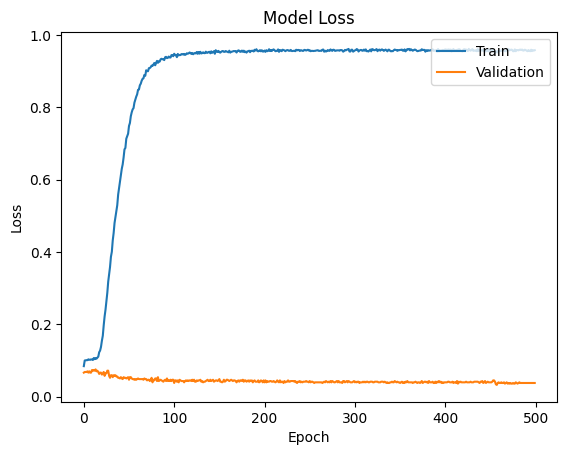

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


- Our model achieves an accuracy around 96% for the training data with RNN vector embeddings. The model slightly overfits, which can be prevented by using early stopping

- Saving and loading our model to generate text

In [24]:
# Saving the model via Tensorflow's save() method
model.save('models/nlp_hindi_model_part_2.h5')  

In [25]:
from tensorflow.keras.models import load_model
# Loading the model
model_rnn = load_model('models/nlp_hindi_model_part_2.h5')

In [ ]:
paragraph = generate_text(
    seed_text       = input("Enter a sentence:"),
    num_sentences   = 1,
    model           = model_rnn,
    max_sequence_len= sequence_length,
    tokenizer       = tokenizer,
    max_length      = 20
)

rnn_res = paragraph.replace("end", "")
rnn_res

Enter a sentence:एक बार एक कुत्ता


'एक बार एक कुत्ता बहुत भूख था वह भोजन की तलाश में इधर उधर गया उसे कसाई की दुकान के पास हड्डी का एक.'

- Our model can build meaningful sentences by using our RNN embeddings. The sentences produced by using Word2Vec model and RNN embedding model is exactly the same.

## 3. ChatBot building with predefined word Embeddings of fasttext

- We'll use Facebook's `fasttext` pre-trained vector embedding for our embedding layer

In [27]:
import fasttext
import fasttext.util
# fasttext.util.download_model('hi', if_exists='ignore')
ft = fasttext.load_model('cc.hi.300.bin')
word1 = "नमस्ते"
word2 = "दुनिया"
# ft.get_word_vector(word1) + ft.get_word_vector(word2)

In [28]:
ft.get_word_vector(word1).shape

(300,)

In [29]:
words_available = ft.get_words()

- Prepare embedding matrix

In [30]:
# Define the size of the word vectors (same as the vector size of Word2Vec)
embedding_dim = ft.get_word_vector(word1).shape[0]

# Create an empty embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # vocab_size is the size of your vocabulary

# Fill the embedding matrix
for word, i in tokenizer.word_index.items():  # word_index is the dictionary of words to indices
    if word in words_available:
        embedding_matrix[i] = ft.get_word_vector(word)

In [31]:
embedding_matrix.shape

(927, 300)

- **Building our chatbot model using Fasttext's vector embeddings**

In [ ]:
model = Sequential()

model.add(Embedding(
    input_dim=vocab_size, 
    output_dim=embedding_dim, 
    weights=[embedding_matrix], 
    input_length=sequence_length, 
    trainable=False
))

# LSTM layer
model.add(LSTM(256, return_sequences=False))

# Output layer
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       278,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,100 (1.06 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 278,100 (1.06 MB)

- Training our model

In [33]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=500, 
    batch_size=64, 
    validation_split=0.2
)

Epoch 1/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0686 - loss: 6.7267 - val_accuracy: 0.0680 - val_loss: 6.5666
Epoch 2/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0922 - loss: 5.7928 - val_accuracy: 0.0680 - val_loss: 6.6387
Epoch 3/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1065 - loss: 5.5202 - val_accuracy: 0.0680 - val_loss: 6.6877
Epoch 4/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1015 - loss: 5.4722 - val_accuracy: 0.0698 - val_loss: 6.7786
Epoch 5/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1166 - loss: 5.3208 - val_accuracy: 0.0751 - val_loss: 6.8415
Epoch 6/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1126 - loss: 5.1517 - val_accuracy: 0.0787 - val_loss: 6.8777
Epoch 7/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1209 - loss: 4.9917 - val_accuracy: 0.0823 - val_loss: 6.9523
Epoch 8/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1409 - loss: 4.7723 - val_accuracy: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9408 - loss: 0.3327 - val_accuracy: 0.0733 - val_loss: 10.1071
Epoch 52/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9470 - loss: 0.3154 - val_accuracy: 0.0716 - val_loss: 10.2699
Epoch 53/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9464 - loss: 0.3087 - val_accuracy: 0.0626 - val_loss: 10.1908
Epoch 54/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9523 - loss: 0.2885 - val_accuracy: 0.0662 - val_loss: 10.2953
Epoch 55/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9552 - loss: 0.2784 - val_accuracy: 0.0698 - val_loss: 10.3045
Epoch 56/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9500 - loss: 0.2591 - val_accuracy: 0.0698 - val_loss: 10.2927
Epoch 57/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9483 - loss: 0.2657 - val_accuracy: 0.0644 - val_loss: 10.2720
Epoch 58/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9586 - loss: 0.2384 - val_accuracy: 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9596 - loss: 0.1022 - val_accuracy: 0.0769 - val_loss: 11.2948
Epoch 102/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9649 - loss: 0.0997 - val_accuracy: 0.0769 - val_loss: 11.3271
Epoch 103/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9677 - loss: 0.0954 - val_accuracy: 0.0680 - val_loss: 11.2024
Epoch 104/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9643 - loss: 0.0984 - val_accuracy: 0.0751 - val_loss: 11.2639
Epoch 105/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9682 - loss: 0.0955 - val_accuracy: 0.0716 - val_loss: 11.2730
Epoch 106/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9704 - loss: 0.0886 - val_accuracy: 0.0733 - val_loss: 11.2801
Epoch 107/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9693 - loss: 0.0878 - val_accuracy: 0.0680 - val_loss: 11.2515
Epoch 108/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9670 - loss: 0.0929 - val_acc

Epoch 151/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9720 - loss: 0.0674 - val_accuracy: 0.0698 - val_loss: 11.7644
Epoch 152/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9629 - loss: 0.0725 - val_accuracy: 0.0680 - val_loss: 11.6903
Epoch 153/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9691 - loss: 0.0653 - val_accuracy: 0.0698 - val_loss: 11.8633
Epoch 154/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9633 - loss: 0.0691 - val_accuracy: 0.0716 - val_loss: 11.8137
Epoch 155/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9671 - loss: 0.0687 - val_accuracy: 0.0769 - val_loss: 11.8237
Epoch 156/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9552 - loss: 0.0869 - val_accuracy: 0.0733 - val_loss: 11.8622
Epoch 157/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9738 - loss: 0.0546 - val_accuracy: 0.0751 - val_loss: 11.8564
Epoch 158/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9670 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9638 - loss: 0.0689 - val_accuracy: 0.0716 - val_loss: 12.1485
Epoch 201/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9664 - loss: 0.0643 - val_accuracy: 0.0733 - val_loss: 12.2099
Epoch 202/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9619 - loss: 0.0668 - val_accuracy: 0.0716 - val_loss: 12.1474
Epoch 203/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0631 - val_accuracy: 0.0698 - val_loss: 12.1945
Epoch 204/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9664 - loss: 0.0585 - val_accuracy: 0.0680 - val_loss: 12.0872
Epoch 205/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9670 - loss: 0.0579 - val_accuracy: 0.0716 - val_loss: 12.2583
Epoch 206/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9720 - loss: 0.0548 - val_accuracy: 0.0751 - val_loss: 12.2265
Epoch 207/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9656 - loss: 0.0664 - val_acc

Epoch 250/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9722 - loss: 0.0510 - val_accuracy: 0.0716 - val_loss: 12.4696
Epoch 251/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9636 - loss: 0.0673 - val_accuracy: 0.0733 - val_loss: 12.5231
Epoch 252/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9675 - loss: 0.0620 - val_accuracy: 0.0751 - val_loss: 12.5117
Epoch 253/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9632 - loss: 0.0609 - val_accuracy: 0.0751 - val_loss: 12.5573
Epoch 254/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9645 - loss: 0.0611 - val_accuracy: 0.0716 - val_loss: 12.5089
Epoch 255/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9603 - loss: 0.0659 - val_accuracy: 0.0716 - val_loss: 12.4821
Epoch 256/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9603 - loss: 0.0600 - val_accuracy: 0.0733 - val_loss: 12.4954
Epoch 257/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9603 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9511 - loss: 0.0821 - val_accuracy: 0.0716 - val_loss: 12.7647
Epoch 300/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9575 - loss: 0.0804 - val_accuracy: 0.0698 - val_loss: 12.4058
Epoch 301/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9635 - loss: 0.0778 - val_accuracy: 0.0590 - val_loss: 12.4455
Epoch 302/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9613 - loss: 0.0958 - val_accuracy: 0.0626 - val_loss: 12.3198
Epoch 303/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9615 - loss: 0.0653 - val_accuracy: 0.0590 - val_loss: 12.3448
Epoch 304/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9632 - loss: 0.0632 - val_accuracy: 0.0698 - val_loss: 12.3742
Epoch 305/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9719 - loss: 0.0519 - val_accuracy: 0.0751 - val_loss: 12.4977
Epoch 306/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9638 - loss: 0.0597 - val_acc

Epoch 349/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9662 - loss: 0.0575 - val_accuracy: 0.0680 - val_loss: 12.7952
Epoch 350/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9655 - loss: 0.0531 - val_accuracy: 0.0680 - val_loss: 12.8154
Epoch 351/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9624 - loss: 0.0550 - val_accuracy: 0.0733 - val_loss: 12.8743
Epoch 352/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9644 - loss: 0.0645 - val_accuracy: 0.0716 - val_loss: 12.8033
Epoch 353/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9676 - loss: 0.0507 - val_accuracy: 0.0716 - val_loss: 12.8363
Epoch 354/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9616 - loss: 0.0638 - val_accuracy: 0.0680 - val_loss: 12.9215
Epoch 355/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9693 - loss: 0.0487 - val_accuracy: 0.0698 - val_loss: 12.8506
Epoch 356/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9621 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9689 - loss: 0.0491 - val_accuracy: 0.0698 - val_loss: 13.0382
Epoch 399/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9634 - loss: 0.0564 - val_accuracy: 0.0733 - val_loss: 13.0336
Epoch 400/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9683 - loss: 0.0533 - val_accuracy: 0.0716 - val_loss: 13.0345
Epoch 401/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9559 - loss: 0.0662 - val_accuracy: 0.0716 - val_loss: 12.9722
Epoch 402/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9650 - loss: 0.0548 - val_accuracy: 0.0716 - val_loss: 13.0812
Epoch 403/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9659 - loss: 0.0554 - val_accuracy: 0.0698 - val_loss: 12.9938
Epoch 404/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9651 - loss: 0.0536 - val_accuracy: 0.0733 - val_loss: 13.0880
Epoch 405/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9640 - loss: 0.0611 - val_acc

Epoch 448/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9638 - loss: 0.0550 - val_accuracy: 0.0698 - val_loss: 13.2044
Epoch 449/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9636 - loss: 0.0548 - val_accuracy: 0.0751 - val_loss: 13.2418
Epoch 450/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9669 - loss: 0.0542 - val_accuracy: 0.0716 - val_loss: 13.2161
Epoch 451/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9673 - loss: 0.0557 - val_accuracy: 0.0716 - val_loss: 13.1813
Epoch 452/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9618 - loss: 0.0599 - val_accuracy: 0.0733 - val_loss: 13.2473
Epoch 453/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9620 - loss: 0.0618 - val_accuracy: 0.0716 - val_loss: 13.2550
Epoch 454/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9674 - loss: 0.0618 - val_accuracy: 0.0733 - val_loss: 13.2704
Epoch 455/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9689 - loss: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9690 - loss: 0.0499 - val_accuracy: 0.0698 - val_loss: 13.4406
Epoch 498/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9651 - loss: 0.0538 - val_accuracy: 0.0698 - val_loss: 13.4334
Epoch 499/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9619 - loss: 0.0637 - val_accuracy: 0.0698 - val_loss: 13.5206
Epoch 500/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9679 - loss: 0.0498 - val_accuracy: 0.0698 - val_loss: 13.4316


- Visualizing our model's accuracy

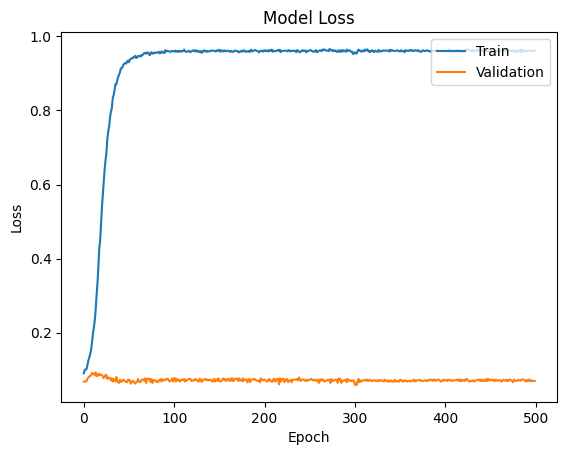

In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

- Our model achieves an accuracy around 96% for the training data with Fasttext vector embeddings. The model slightly overfits, which can be prevented by using early stopping. The performance of this model is same as the model created with RNN embeddings.

- Saving and loading our model to generate text

In [35]:
# Saving the model via Tensorflow's save() method
model.save('models/nlp_hindi_model_part_3.h5')  

In [36]:
from tensorflow.keras.models import load_model
# Loading the model
model_predef_em = load_model('models/nlp_hindi_model_part_3.h5')

In [37]:
paragraph = generate_text(
    seed_text= input("Enter a sentence:"),
    num_sentences=1,
    model=model_predef_em,
    max_sequence_len=sequence_length,
    tokenizer=tokenizer,
    max_length=20
)

ft_res = paragraph.replace("end", "")
ft_res

Enter a sentence:एक बार एक कुत्ता


'एक बार एक कुत्ता बहुत भूख था वह भोजन की तलाश में इधर उधर गया उसे कसाई की दुकान के पास हड्डी का एक.'

- Our model can build meaningful sentences by using our Fasttext embeddings. The sentence generated by using Word2Vec embeddings, RNN embeddings, and Fasttext embeddings is exaclty the same.

---

## Part 4. Embedding Quality Assessment
- Comparative analysis of Word2Vec and RNN-based approaches
- Implementation of multiple evaluation metrics

In [39]:
word2Vec_emb = Word2Vec.load("models/hindi_word2vec.model").wv

print(word2Vec_emb.most_similar("शेर"))

[('किसे', 0.2992207407951355), ('शिक्षा', 0.29796963930130005), ('पूरा', 0.2954152524471283), ('चपके', 0.2797204852104187), ('दी', 0.27207139134407043), ('बना', 0.2716180384159088), ('ढेर', 0.2705824077129364), ('छुपाना', 0.2691693902015686), ('पड़कर', 0.2587142288684845), ('उन्हें', 0.25396525859832764)]


In [40]:
# Create RNN embeddings

from gensim.models import KeyedVectors

embedding_dim = len(next(iter(hindi_embeddings.values())))

rnn_emb = KeyedVectors(vector_size=embedding_dim)

# Add each word and its vector to the KeyedVectors
rnn_emb.add_vectors(list(hindi_embeddings.keys()), list(hindi_embeddings.values()))

print(rnn_emb.most_similar("शेर"))

[('सजा', 0.5530443787574768), ('डालूंगा', 0.4901675879955292), ('क्योंकि', 0.4846453070640564), ('तैर', 0.4808782935142517), ('नामक', 0.4757765233516693), ('बहत', 0.4658587574958801), ('को', 0.4611813426017761), ('एकत्र', 0.46048974990844727), ('रहे', 0.45497849583625793), ('ओझल', 0.44992050528526306)]


In [41]:
# Create fasttext embeddigs

from gensim.models import KeyedVectors

embedding_dim = 300  
ft_emb = KeyedVectors(vector_size=embedding_dim)

# Add words and vectors from the FastText model
for word in hindi_embeddings.keys():
    ft_emb.add_vector(word, ft.get_word_vector(word))

print(ft_emb.most_similar("शेर"))

/Users/devanshugohil/anaconda3/envs/tf-1/lib/python3.10/site-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


[('बाघ', 0.45320555567741394), ('जानवर', 0.4424811005592346), ('सियारों', 0.4065999686717987), ('सियार', 0.39145079255104065), ('हाथी', 0.3724537789821625), ('सिंह', 0.36428454518318176), ('लोमड़ी', 0.36425554752349854), ('कुत्ता', 0.3635978698730469), ('चूहा', 0.35619068145751953), ('हिरण', 0.35594430565834045)]


### Evaluating similarity between words 
- We'll evaluate similarity between 2 words by using Word2Vec embeddings, RNN embeddings, and Fasttext embeddings

In [42]:
from scipy.spatial.distance import cosine

# Define word pairs and analogy pairs for comparison
word_pairs = [('शेर', 'बंदर')]
analogy_test = [('शेर', 'बंदर', 'चूहा')]

# Compare word similarity across embedding models

def compare_word_similarity(embeddings, word_pairs):
    for method_name, model in embeddings.items():
        print(f"Method Name: {method_name}")
        for word1, word2 in word_pairs:
            if word1 in model and word2 in model:
                similarity = 1 - cosine(model[word1], model[word2])
                print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.4f}")
            else:
                print(f"Words '{word1}' or '{word2}' not in vocabulary.")
                
# Run comparisons
compare_word_similarity({
    "Word2Vec": word2Vec_emb,
    "RNN": rnn_emb,
    "fasttext": ft_emb
}, word_pairs)


Method Name: Word2Vec
Cosine similarity between 'शेर' and 'बंदर': -0.1287
Method Name: RNN
Cosine similarity between 'शेर' and 'बंदर': -0.0333
Method Name: fasttext
Cosine similarity between 'शेर' and 'बंदर': 0.3197


### Evaluating multiple words with embedding similarity matrix 

- We'll evaluate similarity between multiple words by using Word2Vec embeddings, RNN embeddings, and Fasttext embeddings and create a similarity matrix

In [43]:
from scipy.stats import spearmanr

# Example word pairs with similarity scores (translated to Hindi if necessary)
word_pairs = [('शेर', 'बंदर'), ('शेर', 'चूहा'), ('बंदर', 'चूहा')]

def evaluate_similarity(embedding_model, word_pairs):
    similarities = []
    for word1, word2 in word_pairs:
        if word1 in embedding_model and word2 in embedding_model:
            sim = embedding_model.similarity(word1, word2)
            similarities.append(sim)
    return similarities

# Evaluate and compare similarity for each embedding set
sim_word2vec = evaluate_similarity(word2Vec_emb, word_pairs)
sim_rnn = evaluate_similarity(rnn_emb, word_pairs)
sim_fasttext = evaluate_similarity(ft_emb, word_pairs)


sim_word2vec, sim_rnn, sim_fasttext

([-0.12870991, 0.10486521, 0.16509901],
 [-0.033317015, 0.047012508, -0.039421435],
 [0.31966025, 0.35619068, 0.32976443])

### Plotting the similarity comparison of various embeddings

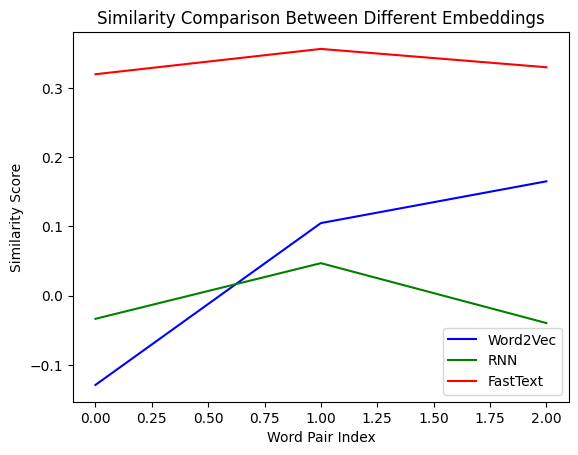

In [ ]:
plt.plot(sim_word2vec, label="Word2Vec", color="blue")
plt.plot(sim_rnn, label="RNN", color="green")
plt.plot(sim_fasttext, label="FastText", color="red")

plt.xlabel("Word Pair Index")  # X-axis: Index of word pairs
plt.ylabel("Similarity Score")  # Y-axis: Similarity score between word pairs
plt.title("Similarity Comparison Between Different Embeddings")

plt.legend()

plt.show()

- FastText appears to be the most reliable for maintaining higher similarity across word pairs.

# Compare Results by results of chatbot

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Load fastText Hindi model
model = fasttext.load_model('cc.hi.300.bin')

# Get sentence embedding by averaging word vectors
def get_sentence_vector(sentence):
    words = sentence.split()  # Simple tokenization
    word_vectors = [model.get_word_vector(word) for word in words]
    return np.mean(word_vectors, axis=0)

In [ ]:
print(word2Vec_res)
print(rnn_res)
print(ft_res)

एक बार एक कुत्ता बहुत भूख था वह भोजन की तलाश में इधर उधर गया  कसाई की जैसे के पीछे गया ना कोई.
एक बार एक कुत्ता बहुत भूख था वह भोजन की तलाश में इधर उधर उड़ा  कसाई  वह  गया  पर उन.
एक बार एक कुत्ता बहुत भूख था वह भोजन की तलाश में इधर उधर उड़ा  कसाई लेकिन के बार एक माफी लकड़हारा और.


### 1. Compare results of word2vec and fasttext text generation 

In [ ]:
vector1 = get_sentence_vector(word2Vec_res)
vector2 = get_sentence_vector(ft_res)

similarity = cosine_similarity([vector1], [vector2])
similarity

array([[0.9690156]], dtype=float32)

### 2. Compare results of RNN embeddings and fasttext text generation 

In [ ]:
vector1 = get_sentence_vector(rnn_res)
vector2 = get_sentence_vector(ft_res)

similarity = cosine_similarity([vector1], [vector2])
similarity

array([[0.9748868]], dtype=float32)

### Conclusion

- From the cosine similarities, we can determine that RNN word embeddings results are accurate that normal Keras Word2Vec embeddings. 